In [7]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Bootstrap
In the previous lecture, we covered about the `Bootstrap`. `Bootstrap` is a method for dealing with the fact that most of the time in real life, we have limited sample. In our previous examples, we had access to the population and took samples from the population. This time, we won't have access to the population anymore. We won't know what the population looks like and we won't be able to take more samples from the population. All we have is one sample, and we have to draw conclusions using that one sample.

<img src = 'bootstrap.jpg' width = 500/>
If we have a population and then we took a sample from the population (let's say we're analyzing median total compensation, recall previous lecture with San Francisco Public Workers dataset), then we can only obtain one median. With **The Bootstrap**, we take that one sample and resample it to obtain samples that look like it came from the population. This way, we can obtain a sense of the variability of our estimate, the population median. 

The reason it works intuitively is, if our sample is large and random, it probably looks like (resembles) the population. Since our original sample looks like the population, the resamples would also look like samples drawn from the population. 

This method might look like too good to be true. It might seem like we made up data. We can actually do this, but we might need to take more statistic classes to study about this more. On the surface level, we can only say that this method works because the sample look similar to the population. 

## Key to Resampling
When we resample, make sure that we:
1. Draw from the original sample at random
2. With replacement
3. As many values as the original sample contained (Recall the public workers example, we had a sample of size 200 workers. The resample has to have the same size of 200).
    * The size of the new sample has to be the same as the original one, so that new 2 estimates are comparable

## Demo
We are going back to the San Francisco Public Employee dataset,

In [8]:
sf = Table.read_table('san_francisco_2015.csv').select(3, 11, 21)
sf.set_format(2, NumberFormatter(0))
sf = sf.where(2, are.above(10000))
sf.show(3)

Organization Group,Job,Total Compensation
"Public Works, Transportation & Commerce",Water Qualitytech I/II,"117,767"
"Public Works, Transportation & Commerce",Soft Floor Coverer,"41,210"
Community Health,Health Care Billing Clerk 2,"110,561"


Above is our population / census. Below is the population distribution,

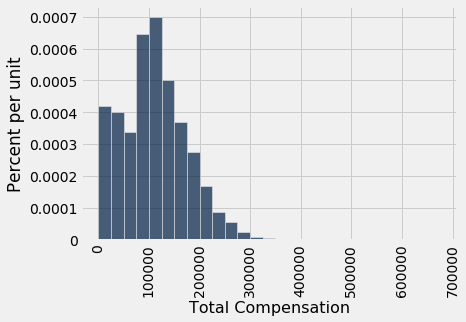

In [9]:
comp_bins = np.arange(0, 700000, 25000) #comp stands for compensation
sf.hist(2, bins = comp_bins)

Above, the median is roughly around 100k. We can double check using `np.median`,

In [10]:
pop_median = np.median(sf.column(2))
pop_median

107219.48

Suppose we only have one sample (pretend that we don't have the original table above and the population distribution). This time, the sample size is 500.

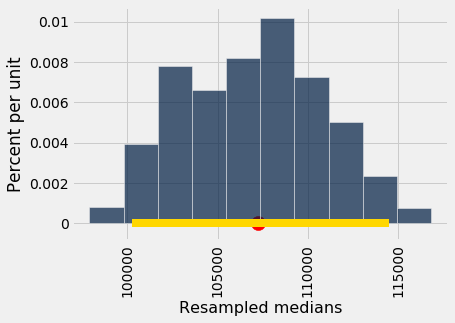

In [11]:
sample_from_population = sf.sample(500, with_replacement = False)

repetitions = 1000
resampled_medians = [] #This is a list

for i in np.arange(repetitions):
    resample = sample_from_population.sample()
    #append the empty "resampled_medians" list
    resampled_medians.append(
        np.median(
            resample.column('Total Compensation')))

# Create an list that contains the 2.5% left tail and the 2.5% right tail
interval_95 = [
    percentile(2.5, resampled_medians),
    percentile(97.5, resampled_medians)
]

Table().with_column('Resampled medians', resampled_medians).hist(0)
plt.plot(interval_95, [0, 0], color = 'gold', lw = 8)
# Also add the actual population median into the histogram.
# It is represented with a red dot.
plt.scatter(pop_median, 0, color = 'red', s = 200)

Above, we used the **bootstrap**, obtained more samples, computed the median of each of the resample, and visualized the computed medians with a histogram. 

Recall from previous lecture that we took the middle 95% of the distribution. We chopped off the 2.5% left tail and the 2.5% right tail and obtain the range represented with the yellow line. This range is called **`Confidence Interval`**. It's representing us saying: "We think the population median falls within this range".

Depending on the sample that we obtain, if the red dot falls within the yellow range, then indeed the population median falls within the `confidence interval`.

**Why did we choose to analyze median in the first place? Why not mean?**

This is because traditional statistical methods (e.g. parametric methods) does not work on median. And thus in this case, we chose a specific example of median so that we don't have to involve the materials taught in normal statistics class.

Below we defined a function `bootstrap_median` that takes in:
1. An original sample taken from the population
2. The label within the sample table that we want to bootstrap
3. The number of repetitions

and the function returns a `list` of computed resample medians. This way, it will be more convenient to take bootstrap median.

In [12]:
def bootstrap_median(sample_from_population, label, repetitions):
    """ Returns a list of resampled medians.
    sample_from_population: An original sample taken from the population
    label: the label within the sample table that we want to bootstrap
    repetitions: the number of repetition
    
    """
    resampled_medians = []
    for i in np.arange(repetitions):
        resample = sample_from_population.sample()
        resampled_medians.append(np.median(resample.column(label)))
    return resampled_medians

### What if our confidence interval does not contain the population median? How likely is it for the population median to fall within the confidence interval?

To find this out, let's run a simulation of constructing 100 confidence intervals and see how many of those 100 contains the population median.

In [13]:
left_ends = [] # left 2.5% cutoff
right_ends = [] # right 2.5% cutoff

for i in np.arange(100):
    #For every repetition, we take a random original sample from the population
    sample_from_pop = sf.sample(200, with_replacement = False)
    # For every repetition, construct a distribution and take the 2.5% left and right cutoff
    medians = bootstrap_median(sample_from_pop, 'Total Compensation', 500)
    left_ends.append(percentile(2.5, medians))
    right_ends.append(percentile(97.5, medians))
    
# Create a table that contains the left and right cutoff
intervals = Table().with_columns(
    'Left end', left_ends,
    'Right end', right_ends
)

In [14]:
intervals.show(3)

Left end,Right end
107609,123459
96888.1,118300
91445.8,109036


From the simulation, we obtain 100 left and right cutoffs that represent 100 of 95% confidence interval. We can calculate how many of these 100 contain the population median by filtering the following:
1. The `left end` must be lower than the population median, and
2. The `right end` must be greater than the population median

In [15]:
(intervals
 .where('Left end', are.below(pop_median))
 .where('Right end', are.above(pop_median))
 .num_rows)

95

Above is the number of intervals, out of 100, that contain the population median! However, the **average number of intervals** that contain the population median should be 95. We say that "we have 95% confidence interval" meaning that if we repeat the entire process of constructing confidence intervals, 95% of the time, our confidence intervals would contain the population median.

Below is a visualization of the intervals constructed above.

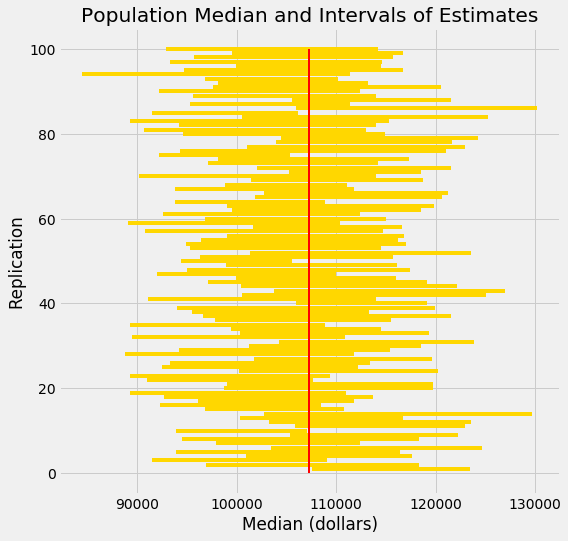

In [16]:
replication_number = np.ndarray.astype(np.arange(1, 101), str)

intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))

plt.figure(figsize=(8,8))
n=100
for i in np.arange(n):
    ends = intervals2.column(i)
    plt.plot(ends, make_array(i+1, i+1), color='gold')
plt.plot(make_array(pop_median, pop_median), make_array(0, n), color='red', lw=2)
plt.xlabel('Median (dollars)')
plt.ylabel('Replication')
plt.title('Population Median and Intervals of Estimates');

Above,
1. The vertical red line in the middle represents the population median
2. Each yellow horizontal line represents one 95% confidence interval

We can see that most of the yellow lines are crossed by the red line, meaning most of the constructed 95% confidence intervals contain the population median. 

# Inference
With this confidence interval, we can do inference.
<img src = 'bootstrap.jpg' width = 500/>
Recall the picture above, which shows why the `bootstrap` works.

This time,
<img src = 'inference.jpg' width = 500/>
the difference is that we don't know what the population looks like. We can't go back to the population and take another sample. What we can do is to construct the confidence interval and say, "we are 95% confidence that the population median is within the interval".

## 95% Confidence Interval
1. The confidence interval is an **interval of estimates of a parameter**.
2. It is based on random sampling
3. The `95%` is called the **confidence level**

Why 95%? Why not any other number?

That percent could be any percent between 0 to 100. Raising the percent means we have more confidence that the population median (or parameter) is in the interval. On the same time, raising the percent means wider, longer intervals.

For example, in San Francisco Public Employee case, we can say that the population median must be somewhere between 0 dollar to 1 billion dollar. We are 100% confidence that median total compensation is within that range. 

However, as we increase the confidence level, we lose accuracy. If we lower the number, the less chance that the population median is within the interval. 

4. The **confidence is in the process** that generated the interval

The entire process of sampling from population, bootstrap, and finally confidence interval, if we repeat this entire process multiple times, we can expect that it will generate a "good" interval (one that contains the population median) 95% of the time. However, there's a caveat.

## Important Note:
"It generates a 'good' interval about 95% of the time." - This means 95% of the time of the whole process, including **taking a random sample from population**. This implies 95% of the time if we take multiple samples from population, **NOT RESAMPLES**.

If our one and only original sample is a bad sample, the interval that can be constructed from the sample will be way off. Even if we try to bootstrap so many times, it will not make that much difference. We can't fix bad sample with bootstrapping. 

## Demo
Here we will go through an example where we don't have access to the population.

Below is a dataset of a **SAMPLE** of newborn babies released by Kaiser Permanente. They were studying whether mothers that smoke affect their babies. The heights are in inches, while the weights are in ounces.

In [17]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


As can be seen above, the data contains 1174 rows, which is definitely not all babies out there. This is not a population, and we don't know what the population looks like. We'll see if we can make a conclusion based on this sample. 

The `Gestational Days` means how long the baby was in the mother's womb. 

For starters, we can take ratios of `Birth Weight` to `Gestational Days` and see if we can find anything interesting. We can start with creating a new table with the relevant columns from the original table.

In [18]:
babies = births.select('Birth Weight', 'Gestational Days')
babies.show(3)

Birth Weight,Gestational Days
120,284
113,282
128,279


Now we can make a table of ratios, in which the ratios can be calculated by dividing the `Birth Weight` with the `Gestational Days`.

In [19]:
ratios = babies.with_column(
    'Ratio BW:GD', babies.column('Birth Weight') / babies.column('Gestational Days')
)
ratios.show(3)

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781


We want to see whether a baby is heavier when it came out of womb if it stayed in the womb longer. On top of that, there is probably an actual ratio that we can use to predict the baby's weight given how many days it stayed in the womb. 

For now, we want to estimate the population BW:GD ratio based on this sample. Let's visualize the distribution of the ratio of the sample,

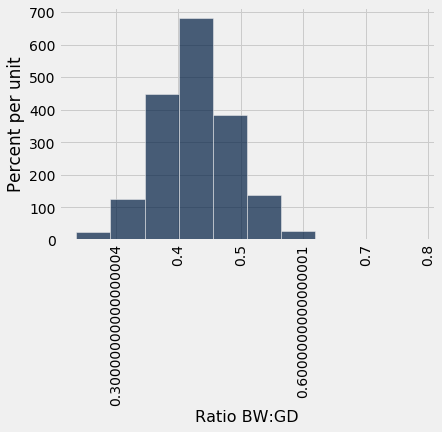

In [20]:
ratios.hist('Ratio BW:GD')

As we can see, in this sample, the most dense ratio fall somewhere between 0.4 to 0.5. We can try looking at the median too!

In [21]:
np.median(ratios.column('Ratio BW:GD'))

0.42907801418439717

According to the result above, if a baby stays in a womb for 100 days, we can expect the baby to weight about 42 pounds.

Recall we defined the `bootstrap_median` method. We can use this method to `boostrap` the sample.

In [22]:
resampled_medians = bootstrap_median(ratios, 'Ratio BW:GD', 5000)
resampled_medians

[0.43103448275862066,
 0.42832681017612523,
 0.4280821917808219,
 0.427536231884058,
 0.4280821917808219,
 0.42857142857142855,
 0.42907187906451694,
 0.4291044776119403,
 0.42961625885813615,
 0.43010752688172044,
 0.4303277666999003,
 0.42916666666666664,
 0.42781524366967805,
 0.4255985598559856,
 0.4254138398914519,
 0.4280821917808219,
 0.432675693101225,
 0.42574257425742573,
 0.4296028880866426,
 0.4278281911675741,
 0.427536231884058,
 0.42857142857142855,
 0.42857142857142855,
 0.43103448275862066,
 0.4296028880866426,
 0.4308176100628931,
 0.4253246753246753,
 0.42907801418439717,
 0.4291044776119403,
 0.43008872847582524,
 0.43010752688172044,
 0.42758620689655175,
 0.4273097826086957,
 0.42805722794070045,
 0.43058026888098067,
 0.4296028880866426,
 0.43103448275862066,
 0.4275092936802974,
 0.4290851107782885,
 0.427536231884058,
 0.43010752688172044,
 0.4303513071895425,
 0.4280821917808219,
 0.42907801418439717,
 0.42781524366967805,
 0.42857142857142855,
 0.426056338028

After we obtain the array of medians above, we can proceed to construct the 95% confidence interval.

Approximate 95% Bootstrap Confidence Interval for the Population Median:
[0.4257 0.4327]


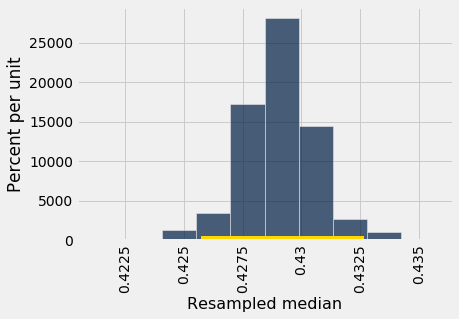

In [23]:
interval_95 = make_array(
    percentile(2.5, resampled_medians),
    percentile(97.5, resampled_medians)
)

Table().with_column('Resampled median', resampled_medians).hist(0)
plt.plot(interval_95, [0, 0], color='gold', lw=8)
print('Approximate 95% Bootstrap Confidence Interval for the Population Median:')
print(np.round(interval_95, 4))

Above, we have the medians of 5,000 bootstrap samples, visualized in a histogram. The yellow horizontal line represents the 95% confidence interval. We are 95% confident that the actual population ratio median falls within the range. 

Earlier, it was explained that if we repeat the whole boostrap process, the interval wouldn't change that much. We can check by running the process above multiple times and see the resulting intervals!

Other than 95%, we can also construct a 80% confidence interval. The process is exactly the same as creating 95% confidence interval, with the only difference of the input number when using the `percentile` function. 80% confidence interval means 10% cutoff on both left tail and right tail.

Approximate 80% Bootstrap Confidence Interval for the Population Median:
[0.4273 0.4306]


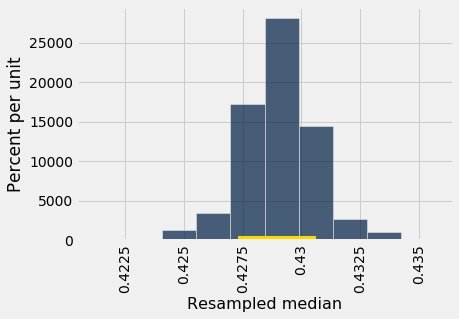

In [24]:
interval_80 = make_array(
    percentile(10, resampled_medians),
    percentile(90, resampled_medians)
)

Table().with_column('Resampled median', resampled_medians).hist(0)
plt.plot(interval_80, [0, 0], color='gold', lw=8)
print('Approximate 80% Bootstrap Confidence Interval for the Population Median:')

print(np.round(interval_80, 4))

As we can see above, the yellow horizontal line is now shorter! We are less confidence that the confidence interval fall within this range. 

# Use Methods Appropriately
There are some cases when bootstrap method does not work. 

## When NOT to Use The Bootstrap
The bootstrap method won't give a good estimation in the following cases:

**1. If we are trying to estimate very high or very low percentiles (e.g. 90th, 85th), or `min` and `max`**

The boostrap depends on whether the original sample is a representative of the population. A very high or low percentile is typically in the tails of the distribution. This means there's a higher chance that the parameter that we are trying to estimate is not within the sample. 

**2. If we are trying to estimate any parameter that's greatly affected by rare elements of the population**

Even if we're trying to estimate the median, if the distribution is U-shaped, the median of the population won't appear that often. In this case, we won't get a good estimate of the median. 

**3. If the probability distribution of the statistic is not roughly bell shaped (the shape of the empirical distribution will be a clue)**

In the past examples, whenever we bootstrapped and constructed the median histogram, the distributions had been roughly symmetrical bell shaped. In these cases, we could use the 95% confidence interval that shaves 2.5% left tail and the 2.5% right tail since we used the assumption that the distribution is symmetrical. If the distribution was not symmetrical bell shaped, it would be more difficult to use the 95% confidence interval. 

After bootstrapping, make sure to look at the shape of the distribution statistic.

**4. If the original sample is very small**

Depending on the case, but rule of thumb is below 50. If it the sample is too small, the sample won't be able to give an accurate estimate. 

The last rule might sound unclear.  However, we want our original sample to represent the population. However, often times we don't know whether our sample represent or does not represent the population. A good recommendation is, if we are working on a case with access to population, we can take a sample and compare the sample's distribution with the population. If we want to know a good sample size for the population, compare the sample distribution with the population distribution and see if they are similar. If they are similar, then we can proceed to bootstrap. 

## Can You Use a CI Like This?
By our calculation, an approximate 95% confidence interval for the average age of the mothers in the population is 26.9, 27.6 years)

Recall we asked why median, why not `mean`? In fact, we can actually do `mean`. Recall the `bootstrap_median` function,

In [25]:
def bootstrap_median(sample_from_population, label, repetitions):
    """ Returns a list of resampled medians.
    sample_from_population: An original sample taken from the population
    label: the label within the sample table that we want to bootstrap
    repetitions: the number of repetition
    
    """
    resampled_medians = []
    for i in np.arange(repetitions):
        resample = sample_from_population.sample()
        resampled_medians.append(np.median(resample.column(label)))
    return resampled_medians

We can create a `bootstrap_mean` method, which look almost exactly the same as `bootstrap_median`, with the only difference is that instead of using `np.median`, we use `np.mean`.

In [26]:
def bootstrap_mean(sample_from_population, label, repetitions):
    """ Returns a list of resampled mean.
    sample_from_population: An original sample taken from the population
    label: the label within the sample table that we want to bootstrap
    repetitions: the number of repetition
    
    """
    resampled_mean = []
    for i in np.arange(repetitions):
        resample = sample_from_population.sample()
        # Below we use np.mean
        resampled_mean.append(np.mean(resample.column(label)))
    return resampled_mean

We can do bootstrap with any statistic other than `mean`. We just have to make sure that the statistic we want to bootstrap is a statistic that appears the sample often. The `mean` is a good choice because often times, it falls in the middle of the sample. 

It would also be convenient if there is a function that automatically constructed the distribution along with the 95% confidence interval line. Thus, we created one below,

In [34]:
def bootstrap_ci_mean(sample_from_population, label, repetitions):
    # Use the `bootstrap_mean` method and store the values in the list "resampled_means"
    resampled_means = bootstrap_mean(sample_from_population, label, repetitions)
    
    # Compute the left 2.5% and right 2.5% cutoffs
    interval_95 = make_array(
        percentile(2.5, resampled_means),
        percentile(97.5, resampled_means)
    )
    
    #Construct the histogram and the 95% Confidence Interval horizontal line
    Table().with_column('Resampled mean', resampled_means).hist('Resampled mean')
    plt.plot(interval_95, [0, 0], color = 'gold', lw = 8)
    print('Approximate 95% Bootstrap Confidence Interval for the Population Mean:')
    print(np.round(interval_95, 3))

Now back to the question of whether we can use the 95% confidence interval for the average age of mothers. 

In [28]:
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


Now let's use the `bootstrap_ci_mean` method to find the 95% confidence interval of the `mean` of the maternal age. Below we bootstrap with 5,000 resamples!

Approximate 95% Bootstrap Confidence Interval for the Population Mean:
[26.89  27.561]


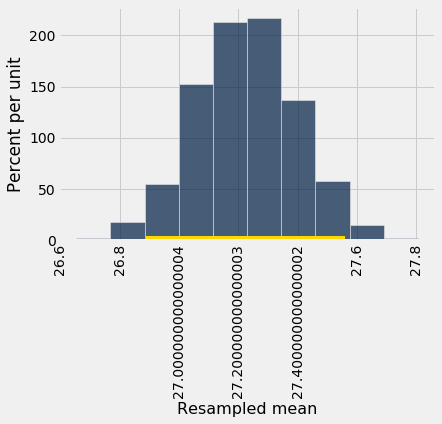

In [35]:
bootstrap_ci_mean(births, 'Maternal Age', 5000)

How do we interpret the result above?

Back to the question, **is it true that about 95% of the mothers in the population were between 26.9 years and 27.6 years old?**

Answer: **NO**

If we look at the distribution of the `Maternal Age` in the sample,

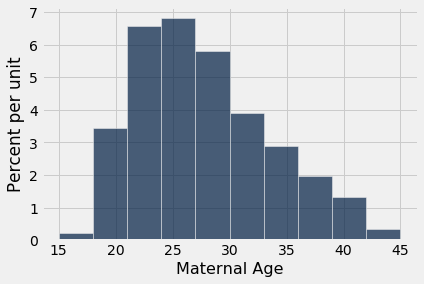

In [36]:
births.hist('Maternal Age')

We can see that the age of mothers are not just around 26.9 to 27.6 years old. They are distributed from 15 to 45 years old! The confidence interval estimated a parameter of the population (in this case, the average of the maternal age). **It did not estimate the distribution of the actual ages of mothers.**

The confidence interval says, "the average maternal age in the population is probably around 27 years old". It doesn't say that "all or most or 95% of the mothers are around 27 years old".